## Import all the libraries

In [1]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [2]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=9;dmax=30
# depth of the desired comparison profile in m
depthmin=1000
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000
# 
debug_plot=False


In [3]:
# Parameters
ymin = 2010
mmin = 1
dmin = 1
ymax = 2010
mmax = 4
dmax = 30
depthmin = 100
radius_max = 0.25
period = 5
number_of_model_profiles = 100000


In [4]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [6]:
sourcefile=open('../'+jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


## Loop on the number of profiles

In [9]:
    prof=53
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    print(prof,outname)


53 /gpfswork/rech/egi/rote001/EN4/profiles_files/MEDWEST60-BLBT02/Profile_20100213_prof_44_MEDWEST60-BLBT02_TS.nc


In [10]:
    # Process one profile
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)

    # Get all infos from json file
    lat_prof = infos[list(list_profiles)[prof]]['latitude']
    lon_prof = infos[list(list_profiles)[prof]]['longitude']
    date_prof = infos[list(list_profiles)[prof]]['date']
    file_prof = infos[list(list_profiles)[prof]]['file']
    prof_prof = infos[list(list_profiles)[prof]]['profile no']
    i0 = infos[list(list_profiles)[prof]]['i0']
    j0 = infos[list(list_profiles)[prof]]['j0']

    # List of all model files involved
    date_profmin=datetime.date(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))-datetime.timedelta(days=int(period))
    date_profmax=datetime.date(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))+datetime.timedelta(days=int(period))
    def date_range(start, end):
        r = (end+datetime.timedelta(days=1)-start).days
        return [start+datetime.timedelta(days=i) for i in range(r)]
    dateList = date_range(date_profmin, date_profmax) 
    dirmod="/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/"
    list_filesmod_T=[]
    list_filesmod_S=[]
    for date in dateList:
        year=date.year
        month=date.month
        day=date.day
        mm="{:02d}".format(month) #month on 2 digits
        dd="{:02d}".format(day) # day on 2 digits
        list_filesmod_T.append(dirmod+'MEDWEST60-BLBT02_y'+str(year)+'m'+str(mm)+'d'+str(dd)+'.1h_gridT.nc')
        list_filesmod_S.append(dirmod+'MEDWEST60-BLBT02_y'+str(year)+'m'+str(mm)+'d'+str(dd)+'.1h_gridS.nc')
    print(list_filesmod_T)  
    
    # Read model files
    dsT=xr.open_mfdataset(list_filesmod_T)
    dsS=xr.open_mfdataset(list_filesmod_S)
    gdpts=np.int(np.round(radius_max*60))

    lonmod=dsT.nav_lon[0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    latmod=dsT.nav_lat[0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    tempmod=dsT.votemper[:,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    saltmod=dsS.vosaline[:,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    depthmod=dsT.deptht
    meshfile='/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-I/mesh_mask.nc'
    ds=xr.open_dataset(meshfile)
    maskmod=ds.tmask[0,:,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]
    maskmod0=ds.tmask[0,0,j0-gdpts:j0+gdpts,i0-gdpts:i0+gdpts]

    #Get the depth at every grid point
    d,ly,lx=maskmod.shape
    depthmod2d=np.zeros([lx,ly])
    for j in np.arange(ly):
        for i in np.arange(lx):
            depthmod2d[j,i]=depthmod[np.min(np.where(maskmod[:,j,i].values<1))].values
    
    # Read the profile file
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    tfileEN4=diren4+file_prof
    dsen4=xr.open_dataset(tfileEN4)
    laten4=dsen4['LATITUDE'][prof_prof]
    lonen4=dsen4['LONGITUDE'][prof_prof]
    dayen4=dsen4['JULD'][prof_prof]
    tempen4=dsen4['TEMP'][prof_prof]
    salten4=dsen4['PSAL'][prof_prof]
    presen4=dsen4['PRES_ADJUSTED'][prof_prof]
    depthen4=seawater.dpth(presen4,laten4)

    # Find the last level and reduce the profiles
    indzprof=np.min(np.where(np.isnan(depthen4)==True))
    dmax=depthen4[indzprof-1]
    obsred_dep=np.zeros(int(indzprof))
    obsred_temp=np.zeros(int(indzprof))
    obsred_salt=np.zeros(int(indzprof))
    for z in np.arange(int(indzprof)):
        obsred_dep[int(z)]=depthen4[int(z)]
        obsred_temp[int(z)]=tempen4[int(z)]
        obsred_salt[int(z)]=salten4[int(z)]

    # Find the model profiles
    lon_stacked = lonmod.stack(profile=('x', 'y'))
    lat_stacked = latmod.stack(profile=('x', 'y'))
    mask_stacked = maskmod0.stack(profile=('x', 'y'))
    xr_depthmod2d=xr.DataArray(depthmod2d, dims=("y", "x"))
    depth_stacked = xr_depthmod2d.stack(profile=('x', 'y'))
    
    distance_threshold = radius_max
    square_distance_to_observation = (lon_stacked - lon_prof)**2 + (lat_stacked-lat_prof)**2
    square_distance_to_observation_mask = np.ma.masked_where(mask_stacked==0.,square_distance_to_observation) 
    square_distance_to_observation_sorted = np.sort(square_distance_to_observation_mask)
    nb_profiles_per_timestep=number_of_model_profiles/(24*period*2+24)
    new_threshold=square_distance_to_observation_sorted[int(np.round(nb_profiles_per_timestep)+1)]
    is_closer_to_observation = (square_distance_to_observation < new_threshold) & (depth_stacked > depthmin)

    model_temperature_stacked = tempmod.stack(profile=('x', 'y'))
    model_salinity_stacked = saltmod.stack(profile=('x', 'y'))

    model_temperature_near_observation = model_temperature_stacked.where(is_closer_to_observation,drop=True)
    model_salinity_near_observation = model_salinity_stacked.where(is_closer_to_observation, drop=True)
    lat_near_observation = lat_stacked.where(is_closer_to_observation, drop=True)
    lon_near_observation = lon_stacked.where(is_closer_to_observation, drop=True)
    
    # Compute statistics on the model profiles
    temp_model_mean = np.mean(model_temperature_near_observation,axis=(0,2))
    temp_percentile_10= np.percentile(model_temperature_near_observation,10,axis=(0,2))
    temp_percentile_90= np.percentile(model_temperature_near_observation,90,axis=(0,2))
    salt_model_mean = np.mean(model_salinity_near_observation,axis=(0,2))
    salt_percentile_10= np.percentile(model_salinity_near_observation,10,axis=(0,2))
    salt_percentile_90= np.percentile(model_salinity_near_observation,90,axis=(0,2))
    
    # Interpolate on obs vertical grid
    temp_model_mean_depobs=np.interp(obsred_dep,depthmod,temp_model_mean)
    temp_model_percentile_10_depobs=np.interp(obsred_dep,depthmod,temp_percentile_10)
    temp_model_percentile_90_depobs=np.interp(obsred_dep,depthmod,temp_percentile_90)
    salt_model_mean_depobs=np.interp(obsred_dep,depthmod,salt_model_mean)
    salt_model_percentile_10_depobs=np.interp(obsred_dep,depthmod,salt_percentile_10)
    salt_model_percentile_90_depobs=np.interp(obsred_dep,depthmod,salt_percentile_90)
    
    # Make a debug plot
    if debug_plot == True:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for profile '+reference
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(temp_model_mean_depobs,obsred_dep,'b.-', label='temp model')
        axs[0].plot(obsred_temp,obsred_dep,'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(2000, 0)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(temp_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[0].plot(temp_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[0].fill_betweenx(obsred_dep, temp_model_percentile_10_depobs, x2=temp_model_percentile_90_depobs, alpha=0.2, facecolor='b')

        axs[1].plot(salt_model_mean_depobs,obsred_dep,'b.-', label='salt model')
        axs[1].plot(obsred_salt,obsred_dep,'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(2000, 0)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(salt_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[1].plot(salt_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[1].fill_betweenx(obsred_dep, salt_model_percentile_10_depobs, x2=salt_model_percentile_90_depobs, alpha=0.2, facecolor='b')
        fig.tight_layout()
        plt.savefig('figs/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'_prof'+str(prof)+'.png')

    # Write netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    if not os.path.exists(dirname):
        os.makedirs(dirname)    
  
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    print('output file is '+outname)
    dsout=Dataset(outname,'w')

    today=date.today()
    dsout.description = "This file contains one profile of temperature and salinity from EN4 dataset and the mean and 10 and 90 percentile of NATL60-CJM165 data within a 0.25deg circle around the location of the profile and 15 days before and after it has been sampled. This file has been created "+str(today.day)+"/"+str(today.month)+"/"+str(today.year)

    depth=dsout.createDimension('depth',len(obsred_dep))
    x=dsout.createDimension('x',1)
    y=dsout.createDimension('y',1)
    
    lat = dsout.createVariable('latitude_profileEN4', 'f8', ('y','x'))
    lat.standart_name="latitude_profileEN4"
    lat.long_name = "Latitude of selected EN4 profile" 
    lat.units = "degrees_north"

    lon = dsout.createVariable('longitude_profileEN4', 'f8', ('y','x'))
    lon.standart_name="longitude_profileEN4"
    lon.long_name = "Longitude of selected EN4 profile" 
    lon.units = "degrees_east"

    time = dsout.createVariable('time_profileEN4', 'f8', ('y','x'))
    time.standart_name="time_profileEN4"
    time.timeg_name = "Time in seconds from 1-1-1958 of selected EN4 profile" 
    time.units = "s"

    depth_en4 = dsout.createVariable('depth_en4', 'f8', ('depth'),fill_value=0.)
    depth_en4.units = "m" 
    depth_en4.valid_min = 0.
    depth_en4.valid_max = 8000.
    depth_en4.long_name = "Depth" 

    temp_en4 = dsout.createVariable('temp_profileEN4', 'f8', ('depth'),fill_value=0.)
    temp_en4.units = "degC" 
    temp_en4.valid_min = -10.
    temp_en4.valid_max = 40.
    temp_en4.long_name = "Temperature profile of the selected EN4 profile" 

    salt_en4 = dsout.createVariable('salt_profileEN4', 'f8', ('depth'),fill_value=0.)
    salt_en4.units = "PSU" 
    salt_en4.valid_min = 20.
    salt_en4.valid_max = 40.
    salt_en4.long_name = "Salinity profile of the selected EN4 profile" 

    mean_temp_model = dsout.createVariable('mean_temp_model', 'f8', ('depth'),fill_value=0.)
    mean_temp_model.units = "degC" 
    mean_temp_model.valid_min = -10.
    mean_temp_model.valid_max = 40.
    mean_temp_model.long_name = "Mean Temperature profile of the model" 

    mean_salt_model = dsout.createVariable('mean_salt_model', 'f8', ('depth'),fill_value=0.)
    mean_salt_model.units = "PSU" 
    mean_salt_model.valid_min = 20.
    mean_salt_model.valid_max = 40.
    mean_salt_model.long_name = "Mean Salinity profile of the model" 

    percent10_temp_model = dsout.createVariable('percent10_temp_model', 'f8', ('depth'),fill_value=0.)
    percent10_temp_model.units = "degC" 
    percent10_temp_model.valid_min = -10.
    percent10_temp_model.valid_max = 40.
    percent10_temp_model.long_name = "Percent 10 Temperature profile of the model" 

    percent10_salt_model = dsout.createVariable('percent10_salt_model', 'f8', ('depth'),fill_value=0.)
    percent10_salt_model.units = "PSU" 
    percent10_salt_model.valid_min = 20.
    percent10_salt_model.valid_max = 40.
    percent10_salt_model.long_name = "Percent 10 Salinity profile of the model" 

    percent90_temp_model = dsout.createVariable('percent90_temp_model', 'f8', ('depth'),fill_value=0.)
    percent90_temp_model.units = "degC" 
    percent90_temp_model.valid_min = -90.
    percent90_temp_model.valid_max = 40.
    percent90_temp_model.long_name = "Percent 90 Temperature profile of the model" 

    percent90_salt_model = dsout.createVariable('percent90_salt_model', 'f8', ('depth'),fill_value=0.)
    percent90_salt_model.units = "PSU" 
    percent90_salt_model.valid_min = 20.
    percent90_salt_model.valid_max = 40.
    percent90_salt_model.long_name = "Percent 90 Salinity profile of the model" 


    lat[:]=lat_prof
    lon[:]=lon_prof
    time[:]=(datetime.datetime(int(date_prof[0:4]),int(date_prof[5:7]),int(date_prof[8:10]))-datetime.datetime(1958,1,1,0,0)).total_seconds()
    depth_en4[:]=obsred_dep
    temp_en4[:]=obsred_temp
    salt_en4[:]=obsred_salt
    mean_temp_model[:]=temp_model_mean_depobs
    mean_salt_model[:]=salt_model_mean_depobs
    percent10_temp_model[:]=temp_model_percentile_10_depobs
    percent10_salt_model[:]=salt_model_percentile_10_depobs
    percent90_temp_model[:]=temp_model_percentile_90_depobs
    percent90_salt_model[:]=salt_model_percentile_90_depobs
    dsout.close()  # close the new file
    

Processing profile  Profile_20100213_prof.nc_44
['/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d08.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d09.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d10.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d11.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d12.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d13.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d14.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d15.1h_gridT.nc', '/gpfsstore/rech/egi/commun/MEDWEST60/extracted_eNATL60/allv/MEDWEST60-BLBT02_y2010m02d16.1h_gridT.nc', '/gpfsstore/rec

In [135]:
    xr_depthmod2d=xr.DataArray(depthmod2d, dims=("y", "x"))
    depth_stacked = xr_depthmod2d.stack(profile=('x', 'y'))


In [136]:
depth_stacked[362].values

array(56.79595184)

In [113]:
model_temperature_stacked[:,25,362].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [114]:
model_temperature_stacked.indexes['profile'][362]

(12, 2)

In [115]:
tempmod[:,25,2,12].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [116]:
xr_depthmod2d[2,12].values

array(56.79595184)

In [122]:
xr_depthmod2d

<xarray.DataArray (x: 30, y: 30)>
array([[4.81652649e+02, 4.21237915e+02, 3.32538330e+02, 2.10041290e+02,
        1.34580063e+02, 1.09033005e+02, 1.03061752e+02, 9.16180191e+01,
        8.08391113e+01, 7.07244797e+01, 6.12732086e+01, 4.83372383e+01,
        3.68851204e+01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01],
       [6.13528625e+02, 5.45784058e+02, 4.33018829e+02, 3.11928467e+02,
        2.10041290e+02, 1.41382019e+02, 1.09033005e+02, 9.72567673e+01,
        8.61454926e+01, 7.56988144e+01, 6.59159927e+01, 5.67959518e+01,
        4.83372383e+01, 3.68851204e+01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01, 4.80454773e-01, 4.80454773e-01,
        4.80454773e-01, 4.80454773e-01],
       [7.29156006e+02, 6.99434814e+02, 5.86004150e+02, 4.57035217e+02,
        4.09609467e+02, 3.43080200e+02, 2.01753662e+02, 1.15170502e+02,
        9.72567673e+01, 8.61454926e+01, 7.56988144e+01, 6.59159927e+01,
        5.67959518e+01, 4.83372383e+01, 4.43553276e+01, 4.80454773e-01,
...
        1.64349304e+03, 1.64349304e+03, 1.64349304e+03, 1.64349304e+03,
        1.62311621e+03, 1.62311621e+03, 1.62311621e+03, 1.62311621e+03,
        1.62311621e+03, 1.60282104e+03, 1.58260840e+03, 1.58260840e+03,
        1.56247937e+03, 1.58260840e+03],
       [1.70510449e+03, 1.70510449e+03, 1.72579883e+03, 1.72579883e+03,
        1.72579883e+03, 1.70510449e+03, 1.64349304e+03, 1.50260315e+03,
        1.60282104e+03, 1.66395068e+03, 1.66395068e+03, 1.66395068e+03,
        1.66395068e+03, 1.66395068e+03, 1.68448816e+03, 1.66395068e+03,
        1.66395068e+03, 1.66395068e+03, 1.66395068e+03, 1.64349304e+03,
        1.64349304e+03, 1.64349304e+03, 1.64349304e+03, 1.64349304e+03,
        1.64349304e+03, 1.62311621e+03, 1.60282104e+03, 1.60282104e+03,
        1.60282104e+03, 1.60282104e+03],
       [1.72579883e+03, 1.72579883e+03, 1.72579883e+03, 1.74657031e+03,
        1.72579883e+03, 1.72579883e+03, 1.70510449e+03, 1.58260840e+03,
        1.54243481e+03, 1.68448816e+03, 1.68448816e+03, 1.68448816e+03,
        1.68448816e+03, 1.68448816e+03, 1.68448816e+03, 1.68448816e+03,
        1.68448816e+03, 1.68448816e+03, 1.66395068e+03, 1.66395068e+03,
        1.66395068e+03, 1.66395068e+03, 1.66395068e+03, 1.66395068e+03,
        1.64349304e+03, 1.64349304e+03, 1.62311621e+03, 1.62311621e+03,
        1.62311621e+03, 1.64349304e+03]])
Dimensions without coordinates: x, y

In [117]:
maskmod0[2,12].values

array(1, dtype=int8)

In [70]:
ind=np.where(is_closer_to_observation==False)

In [120]:
depth_stacked[362].values

array(1404.57067871)

In [132]:
depth_stacked[362].values

array(1404.57067871)

In [133]:
depth_stacked.indexes['profile'][362]

(12, 2)

In [134]:
xr_depthmod2d[12,2].values

array(1404.57067871)

In [118]:
is_closer_to_observation[362].values

array(True)

In [79]:
is_closer_to_observation.values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [78]:
ind[0][100]

100

In [81]:
model_temperature_near_observation=1*model_temperature_stacked.values
for n in range(len(ind[0])):
    model_temperature_near_observation[:,:,int(ind[0][n])]=np.nan
    

In [101]:
depth_stacked[362].values

array(1404.57067871)

In [103]:
mask_stacked[362].values

array(1, dtype=int8)

In [106]:
mask_stacked.indexes['profile'][362]

(12, 2)

In [104]:
model_temperature_near_observation[:,25,362]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [99]:
for n in range(900):
    if n not in ind[0]:
        print(n,model_temperature_near_observation[:,25,n])

188 [14.812446  14.811782  14.811074  14.810727  14.811259  14.812917
 14.815462  14.818384  14.821307  14.824296  14.827477  14.830757
 14.834063  14.837487  14.841458  14.846474  14.852865  14.8604555
 14.868257  14.874745  14.878421  14.878485  14.874636  14.866868
 14.855866  14.843013  14.829846  14.817772  14.807789  14.800218
 14.794992  14.791834  14.790378  14.790215  14.791044  14.792569
 14.794309  14.795898  14.7972145 14.798257  14.799027  14.7994585
 14.79947   14.798979  14.797977  14.796625  14.795237  14.794071
 14.793142  14.792312  14.791575  14.791005  14.790387  14.789389
 14.787934  14.786212  14.784266  14.782371  14.780632  14.778641
 14.7762375 14.773529  14.770884  14.768725  14.767113  14.765931
 14.765039  14.764262  14.763516  14.762749  14.761817  14.76036
 14.757905  14.753999  14.748752  14.742101  14.7336235 14.722378
 14.709447  14.695635  14.680124  14.665174  14.658033  14.65939
 14.660453  14.65981   14.657877  14.653788  14.648192  14.642012
 14.63

512 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
513 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [93]:
depth_stacked[188].values

array(409.60946655)

In [87]:
ind[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [89]:
    temp_model_mean = np.nanmean(model_temperature_near_observation,axis=(0,2))
    temp_percentile_10= np.nanpercentile(model_temperature_near_observation,10,axis=(0,2))
    temp_percentile_90= np.nanpercentile(model_temperature_near_observation,90,axis=(0,2))


In [91]:
temp_percentile_10

array([14.34841824, 14.34769249, 14.34677839, 14.34577084, 14.34510612,
       14.34450769, 14.34397554, 14.34317303, 14.34258032, 14.3421216 ,
       14.34190035, 14.34169436, 14.34152746, 14.34146357, 14.34130096,
       14.3408618 , 14.33510065, 14.33469296, 14.33037996, 14.3234849 ,
       14.3227253 , 14.31752729, 14.30852032, 14.29949331,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [85]:
model_temperature_near_observation

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [84]:
temp_model_mean.shape

(212,)

In [90]:
print(temp_model_mean)

[14.279175   14.274758   14.272588   14.271314   14.270479   14.269906
 14.269589   14.269558   14.269719   14.269956   14.270174   14.270247
 14.270085   14.26965    14.268945   14.268053   14.132867   14.131603
 14.040275   13.903765   13.901888   13.809851   13.6279745  13.446014
 13.038058   12.71989    12.312179   11.860643   11.455134   11.049949
 10.7777605  10.59186    10.489878   10.424808   10.395985   10.314225
 10.182839   10.120015    9.956239    9.7922125   9.718778    9.610183
  9.510083    9.416686    9.372208    9.211446    9.137648    9.071813
  9.050328    9.033186    9.018831    8.967462    8.958548    8.951661
  8.94609     8.941238    8.936807    8.93227     8.927759    8.842428
  8.797245    8.752132    8.666505    8.580607    8.53484     8.448815
  8.442979    8.397162    8.39132     8.345631    8.339947    8.33457
  8.329231    8.284209    8.199217    8.114614    8.1100645   8.065932
  8.021789    7.9780526   7.974149    7.890902    7.847503    7.804483
  7.761

In [69]:
model_temperature_near_observation=0*model_temperature_stacked
for i in range(model_temperature_stacked.shape[0]):
    for j in range(model_temperature_stacked.shape[1]):
        model_temperature_near_observation[i,j,:] = model_temperature_stacked[i,j].where(is_closer_to_observation,drop=True)

IndexError: dimension coordinate 'profile' conflicts between indexed and indexing objects:
<xarray.DataArray 'profile' (profile: 329)>
array([(6, 8), (6, 9), (6, 10), ..., (23, 16), (23, 17), (23, 18)],
      dtype=object)
Coordinates:
    deptht        float32 0.48045477
    time_counter  datetime64[ns] 2010-02-08T00:30:00
  * profile       (profile) MultiIndex
  - x             (profile) int64 6 6 6 6 7 7 7 7 7 ... 23 23 23 23 23 23 23 23
  - y             (profile) int64 8 9 10 11 7 8 9 10 ... 11 12 13 14 15 16 17 18
vs.
<xarray.IndexVariable 'profile' (profile: 900)>
array([(0, 0), (0, 1), (0, 2), ..., (29, 27), (29, 28), (29, 29)], dtype=object)

In [66]:
model_temperature_stacked.shape

(264, 212, 900)

In [65]:
is_closer_to_observation[50].values

array(False)

In [58]:
model_temperature_near_observation[0,24,50].values

array(14.971484, dtype=float32)

In [61]:
depth_stacked[50].values

array(0.48045477)

In [34]:
truc=model_temperature_near_observation[:,25,:]

In [36]:
truc

<xarray.DataArray 'votemper' (time_counter: 264, profile: 329)>
dask.array<getitem, shape=(264, 329), dtype=float32, chunksize=(24, 329), chunktype=numpy.ndarray>
Coordinates:
    deptht        float32 75.698814
  * time_counter  (time_counter) datetime64[ns] 2010-02-08T00:30:00 ... 2010-...
  * profile       (profile) MultiIndex
  - x             (profile) int64 6 6 6 6 7 7 7 7 7 ... 23 23 23 23 23 23 23 23
  - y             (profile) int64 8 9 10 11 7 8 9 10 ... 11 12 13 14 15 16 17 18
Attributes:
    units:             degC
    valid_min:         0.0
    valid_max:         0.0
    long_name:         temperature
    short_name:        N/A
    iweight:           1
    online_operation:  average
    axis:              N/A
    savelog10:         0.0

In [37]:
truc1D=np.zeros([truc.shape[0]*truc.shape[1]])

In [39]:
len(truc1D)

86856

In [42]:
truc.shape

(264, 329)

In [47]:
np.percentile(truc.values,20)

14.330004692077637

In [48]:
ind=np.where(truc.values==0)

In [52]:
print(ind[0][0],ind[1][0])

0 50


In [54]:
truc[0,50].values

array(0., dtype=float32)

In [45]:
truc.values

array([[14.812446 , 14.817731 , 14.827638 , ..., 14.875219 , 14.863218 ,
        14.871464 ],
       [14.811782 , 14.818054 , 14.82796  , ..., 14.872888 , 14.863444 ,
        14.863597 ],
       [14.811074 , 14.818066 , 14.827796 , ..., 14.868467 , 14.863835 ,
        14.856711 ],
       ...,
       [14.325249 , 14.30344  , 14.294911 , ..., 14.412021 , 14.418636 ,
        14.405133 ],
       [14.323307 , 14.3018875, 14.294177 , ..., 14.411282 , 14.415508 ,
        14.400912 ],
       [14.321405 , 14.300379 , 14.293477 , ..., 14.410481 , 14.412212 ,
        14.39667  ]], dtype=float32)

In [40]:
for i in range(truc.shape[0]):
    for j in range(truc.shape[1]):
        truc1D[(j-1)*truc.shape[0]+i]=truc[i,j]

IndexError: Index is not smaller than dimension 264 >= 264

In [ ]:
truc1D

In [25]:
print(temp_model_mean.values)

[14.279172   14.274758   14.272586   14.271314   14.2704735  14.269897
 14.269587   14.269554   14.269711   14.269957   14.270168   14.270247
 14.270092   14.269659   14.268953   14.26805    14.132868   14.131613
 14.040277   13.903774   13.901879   13.809854   13.627991   13.446026
 13.038054   12.719901   12.312186   11.860642   11.4551325  11.049946
 10.777751   10.591858   10.489876   10.424811   10.395979   10.314226
 10.182837   10.120016    9.956237    9.7922125   9.718779    9.610183
  9.51008     9.416693    9.372208    9.211442    9.137654    9.071822
  9.050332    9.03319     9.018834    8.967461    8.9585495   8.951663
  8.946108    8.941244    8.9368105   8.932283    8.9277525   8.84242
  8.797239    8.752137    8.666505    8.580606    8.534836    8.448821
  8.442976    8.397158    8.39132     8.345632    8.339947    8.334574
  8.329232    8.2842045   8.199215    8.114611    8.110068    8.065932
  8.02179     7.9780507   7.9741483   7.890905    7.8475046   7.8044767
  7.76

In [23]:
print(temp_percentile_10)

[14.34841824 14.34769249 14.34677839 14.34577084 14.34510612 14.34450769
 14.34397554 14.34317303 14.34258032 14.3421216  14.34190035 14.34169436
 14.34152746 14.34146357 14.34130096 14.3408618  14.33510065 14.33469296
 14.33037996 14.3234849  14.3227253  14.31752729 14.30852032 14.29949331
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.      

In [19]:
print(model_temperature_near_observation.values)

[[[14.861222  14.813042  14.822011  ... 14.869168  14.853596  14.846744 ]
  [14.861225  14.813045  14.822015  ... 14.869171  14.853598  14.846746 ]
  [14.861227  14.813047  14.822018  ... 14.869175  14.853601  14.846749 ]
  ...
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[14.86165   14.809986  14.820409  ... 14.865589  14.85121   14.843242 ]
  [14.861653  14.809989  14.820412  ... 14.865592  14.8512125 14.843245 ]
  [14.861655  14.809992  14.820415  ... 14.865595  14.851215  14.843247 ]
  ...
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[14.866339  14.807809  14.818582  ... 14.861606  14.84822   14.840304 ]
  [14.866342  14.80781

In [17]:
print(temp_percentile_90)

[14.9356761  14.93241596 14.93107891 14.93014526 14.92979813 14.92951059
 14.92923403 14.92922974 14.92909336 14.92905426 14.92850971 14.92782307
 14.92685795 14.926054   14.92481089 14.92353392 14.9209137  14.91996336
 14.91544676 14.90746069 14.90159559 14.89128017 14.8783493  14.86400366
 14.84602976 14.83760786 14.83056021 14.82381535 14.81248379 14.79011536
 14.75873327 14.71299696 14.66393423 14.61256886 14.5646224  14.51622677
 14.46638393 14.41398954 14.31442213 14.19377279 14.07472563 13.96253777
 13.85820675 13.75806808 13.66844654 13.59420109 13.532341   13.48341227
 13.44293976 13.40958643 13.38245964 13.36194944 13.34612274 13.33369398
 13.32397938 13.31596231 13.30911827 13.30235672 13.29567051 13.28904963
 13.28189421 13.27494001 13.26809788 13.26028872 13.25210476 13.24400568
 13.23500776 13.22643566 13.21735859 13.20897484 13.20002508 13.19150925
 13.18314695 13.17559767 13.16737366 13.15947914 13.15179205 13.14533615
 13.13814163 13.13194418 13.1253171  13.11927938 13

In [14]:
print(temp_model_mean_depobs)

[14.26955788 14.26969334 14.27001415 14.2701964  14.27018971 14.26993393
 14.26946389 14.26865836 14.22025645 14.13262006 14.13054487 14.06170202
 13.96554051 13.90323754 13.90179358 13.83827413 13.74708371 13.62625791
 13.51739128 13.36484753 13.12918256 12.92909944 12.71968505 12.46004096
 12.22602184 11.98123819 11.75250343 11.54670443 11.33723735 11.09490505
 10.92580608 10.79558472 10.70313524 10.60432926 10.54577825 10.49963456
 10.46829858 10.43656522 10.41574333 10.40204261 10.37486721 10.34310166
 10.30203312 10.24456628 10.18901558 10.15532272 10.12939565 10.07787798
 10.01185592  9.94605492  9.87475066  9.80121861  9.76786663  9.74055408
  9.7051226   9.66560734  9.62609273  9.5850651   9.54686588  9.50762628
  9.47389072  9.43899267  9.41135629  9.39398364  9.37661149  9.33396195
  9.27434725  9.21858048  9.18955498  9.16185951  9.1353571   9.11338946
  9.09142205  9.07082119  9.06354089  9.05674607  9.04946382  9.04433253
  9.03768098  9.03235083  9.0276616   9.02312865  9

In [15]:
print(temp_model_percentile_10_depobs)

[14.34326554 14.34264549 14.34206145 14.34182723 14.34163236 14.34150413
 14.3414186  14.34115753 14.33882494 14.33502017 14.33464253 14.3313917
 14.32660486 14.32326975 14.32272045 14.31913261 14.31441854 14.30843435
 14.30303364 11.45417416  3.19406127  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  

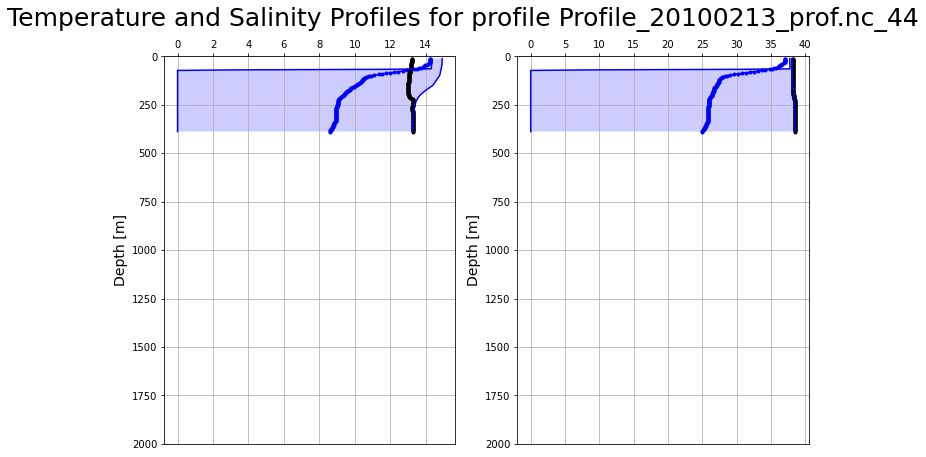

In [12]:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for profile '+reference
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(temp_model_mean_depobs,obsred_dep,'b.-', label='temp model')
        axs[0].plot(obsred_temp,obsred_dep,'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(2000, 0)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(temp_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[0].plot(temp_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[0].fill_betweenx(obsred_dep, temp_model_percentile_10_depobs, x2=temp_model_percentile_90_depobs, alpha=0.2, facecolor='b')

        axs[1].plot(salt_model_mean_depobs,obsred_dep,'b.-', label='salt model')
        axs[1].plot(obsred_salt,obsred_dep,'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(2000, 0)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(salt_model_percentile_10_depobs,obsred_dep,'b-', label='percent10')
        axs[1].plot(salt_model_percentile_90_depobs,obsred_dep,'b-', label='percent90')
        axs[1].fill_betweenx(obsred_dep, salt_model_percentile_10_depobs, x2=salt_model_percentile_90_depobs, alpha=0.2, facecolor='b')
        fig.tight_layout()

